# Equilibrio bid

En este ejemplo, programaremos un modelo de localización mediante bid. Es decir, calculamos la probabilidad de que un hogar sea el mejor postor en una localizacion, P(h│i). En este caso las funciones de utilidad dependerá de tres parámetros: acc_educ, acc_comercio, Nro_hg_h1_en_zona. Serán tres tipos de agentes: Hogares tipo 1, Hogares tipo 2 y Hogares tipo 3.

$P(h│i)=H_h*exp⁡(μ (DP_hi+DP_h))/(∑_gH_g exp⁡((μ DP_gi+DP_g)) )$

A continuación se especifican los pasos a seguir (cargar la imagen si no se ve)

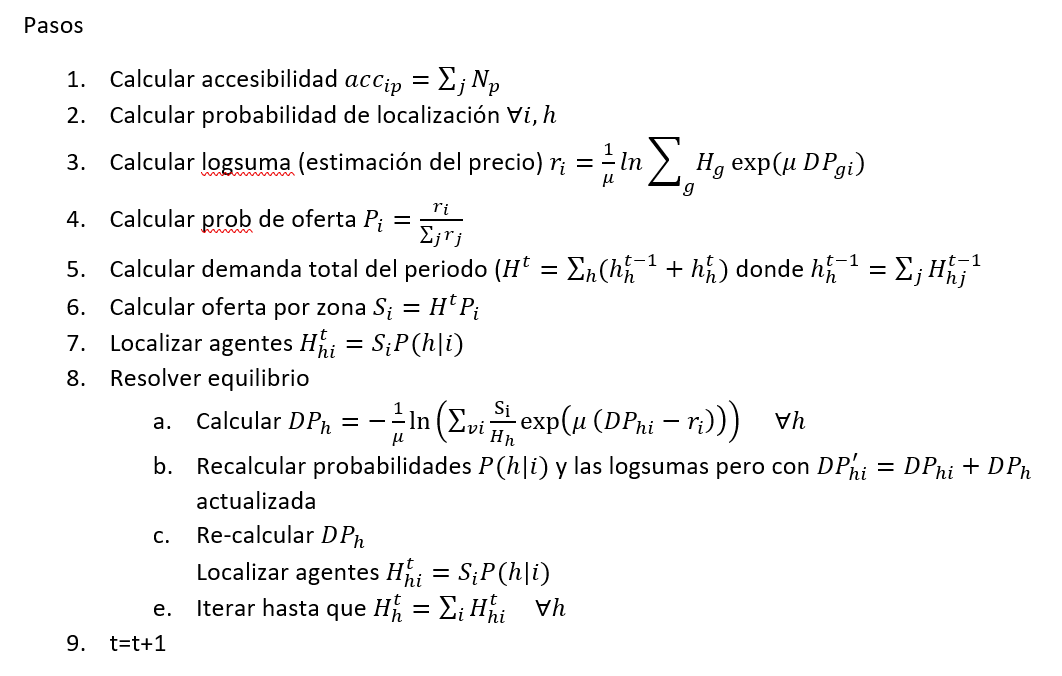

In [9]:
#EJECUTAR ACA PARA VER IMAGEN
#Esto no es parte del codigo de la simulacion

from IPython.display import Image
Image("Captura.png")

Se crean dos clases al igual que para el ejemplo choice. 

In [11]:
import math
from copy import copy

# =============================================================================
# CLASES
# =============================================================================

class zona_obj:
    def __init__(self, idi, comercio, educacion, n_h1, 
                 n_h2, n_h3, cap_res, cap_no_res, precio):
        self.id = idi
        self.comercio = comercio
        self.educacion = educacion
        self.n_h1= n_h1
        self.n_h2= n_h2
        self.n_h3= n_h3
        self.cap_res = cap_res
        self.cap_no_res = cap_no_res
        self.precio = precio

#clase de agentes por localizar por periodo
class por_localizar_obj:
    def __init__(self, periodo, h1, h2, h3):
        self.periodo = periodo
        self.n_h1 = h1
        self.n_h2 = h2
        self.n_h3 = h3

def leer_archivo(nombre_archivo):
    lista_datos = []
    archivo_aux=open(nombre_archivo, 'r')
    linea = archivo_aux.readlines()
    for l in linea:
        if linea.index(l)>=1:
            lista_datos.append(l.split())
    archivo_aux.close()
    return lista_datos
        

También se mantienen las funciones leer_archivos y calcular_accesibilidad

In [12]:
def leer_archivo(nombre_archivo):
    lista_datos = []
    archivo_aux=open(nombre_archivo, 'r')
    linea = archivo_aux.readlines()
    for l in linea:
        if linea.index(l)>=1:
            lista_datos.append(l.split())
    archivo_aux.close()
    return lista_datos
        
def calcular_accesibilidad(periodo, zona, costos_dict, n_zonas, phi):        
    Accesibilidad_comercio= []
    Accesibilidad_educacion = []
    for i in range(1,(n_zonas+1)):
        acc_aux_comercio = 0
        acc_aux_educacion = 0
        for j in range(1, (n_zonas+1)):
            acc_aux_comercio += zona[periodo,j].comercio*math.exp(-phi*costos_dict[i,j])
            acc_aux_educacion += zona[periodo,j].educacion*math.exp(-phi*costos_dict[i,j])
        Accesibilidad_comercio.append(int(acc_aux_comercio))
        Accesibilidad_educacion.append(int(acc_aux_educacion))
    return Accesibilidad_comercio, Accesibilidad_educacion
        

Creamos funciones para calcular DPhi y probabilidad(h│i), calcular_DPhi y calcular_prob_localizacion. Para la probabilidad se crearon dos funciones casi iguales. La diferencia es que la primera no usa la variable Hh, esta función solo se usa para la primera iteración de cada periodo en la que no se ha definido un Hh, luego al iterar y exista un Hh se usará la segunda función que calcula probabilidad. 

In [13]:
def calcular_DPhi(betas, acc_comercio, acc_educacion, zona, periodo):
    n_zonas = len(acc_comercio)
    t = periodo
    DPhi ={}
    for i in range(1, n_zonas + 1):
        for agente in betas:
            DPhi[agente,i] = (betas[agente][0]*acc_educacion[i-1] 
                          + betas[agente][1]*acc_comercio[i-1]
                          + betas[agente][2]*zona[t,i].n_h1)     
    return DPhi


def calcular_prob_localizacion(betas, n_zonas, zona, DP, mu, DPh):
    prob_aux2 = 0
    prob_aux1 = {}
    prob= {}
    for i in range(1, (n_zonas + 1)):
        prob_aux = 0
        for h in betas:
            suma = math.exp(mu*(DP[h,i]+DPh[h]))
            prob_aux += suma
        prob_aux1[i] = prob_aux   
    
    for i in range(1, (n_zonas+1)):
        for h in betas:

            prob_aux2 = math.exp(mu*(DP[h,i]+DPh[h]))
            prob_aux3 = prob_aux1[i]
            prob[h,i]= prob_aux2/prob_aux3
    return prob

def calcular_prob_localizacion_conH(betas, n_zonas, zona, DP, mu, DPh, Hh):
    prob_aux2 = 0
    prob_aux1 = {}
    prob= {}
    for i in range(1, (n_zonas + 1)):
        prob_aux = 0
        for h in betas:
            suma = (math.exp(mu*(DP[h,i]+DPh[h])))*Hh[h]
            prob_aux += suma
        prob_aux1[i] = prob_aux   
    
    for i in range(1, (n_zonas+1)):
        for h in betas:
            prob_aux2 = Hh[h]*math.exp(mu*(DP[h,i]+DPh[h]))
            prob_aux3 = prob_aux1[i]
            prob[h,i]= prob_aux2/prob_aux3
    return prob

Se crean funciones para calcular las logsumas $r_i$ y las probabilidades de oferta $P_i$. Al igual que las probabilidades de localización, la función para calcular logsuma tiene dos versiones, una para la primera iteración, en donde Hh no se ha calculado y otra para el resto de las iteraciones. 

In [14]:
def calcular_logsuma(DP, mu, Hh):
    r={}
    for i in range(1, n_zonas + 1):
        r_aux = 0
        for h in betas:
            r_aux += (math.exp(mu*DP[h,i]))*Hh[h]
        r[i] = math.log(r_aux)/mu
    return r

def calcular_logsuma1(DP, mu):
    r={}
    for i in range(1, n_zonas + 1):
        r_aux = 0
        for h in betas:
            r_aux += (math.exp(mu*DP[h,i]))
        r[i] = math.log(r_aux)/mu
    return r


def calcular_prob_oferta(r):
    P = {}
    r_sum = 0
    for i in range(1, (n_zonas +1)):
        r_sum += r[i]
    for i in range(1, (n_zonas +1)):
        P[i] = r[i]/r_sum
    return P

Generamos funciones para contabilizar cuánto es la demanda por localización para el periodo y por agente. Estas se separaron en dos funciones, pero perfectamente podría ser una sola función que calcule ambas simultáneamente. 

In [15]:
def calcular_demanda_H(t):
    demandaH = 0
    for i in range(1, 1 + n_zonas):
        demandaH += zona[t-1,i].n_h1 + zona[t-1,i].n_h2 + zona[t-1,i].n_h3 
    demandaH +=  por_localizar_dict[t].n_h1 + por_localizar_dict[t].n_h2 + por_localizar_dict[t].n_h3
    return demandaH

def calcular_Hh_demanda(t):
    H1 = 0
    H2 = 0
    H3 = 0
    Hh = {}
    for i in range(1, 1 + n_zonas):
        H1 += zona[t-1,i].n_h1
        H2 += zona[t-1,i].n_h2
        H3 += zona[t-1,i].n_h3
    H1 += por_localizar_dict[t].n_h1
    H2 += por_localizar_dict[t].n_h2
    H3 += por_localizar_dict[t].n_h3
    Hh = {"n_h1":H1, "n_h2":H2, "n_h3":H3}
    return Hh

En este caso se calculó la  oferta de forma endógena, mediante $Hh*Pi$. En el archivo zonas_t0.txt se encuentra la capacidad residencial de cada zona, con esa inforamción se podría definir la oferta exógenamente y tiene sentido hacerlo cuando se cuenta con los datos.

In [16]:
def calcular_oferta_S(t, demandaH,P):
    S = {}
    for i in range(1, n_zonas + 1):
        S[i]= demandaH*P[i]
    return S

In [17]:
def localizar_agentes(demandaH, S, P_hi):
    H = {}
    for i in range(1, n_zonas + 1):
        for h in betas:
            H[h,i]= S[i]*P_hi[h,i]
    return H


def calcular_DPh(S, DPhi, r, H, mu,Hh):
    DPh = {}
    for h in betas:
        suma_aux = 0
        for i in range(1, n_zonas+1):
            #suma_aux += (S[i]/Hh[h])*math.exp(mu*(DPhi[h,i] - r[i]))
            suma_aux += math.exp(mu*(DPhi[h,i] - r[i]))
        DPh[h]= (-1/mu)* math.log(suma_aux)
    return DPh

def recalcular_DPhi(DP, DPh):
    DPnuevo = {}
    for h in betas:
        for i in range(1, n_zonas+1):
            DPnuevo[h,i]= DP[h,i] + DPh[h]
    return DPnuevo

def calcular_Hh_localizados(H):
    Hh_localizados = {}
    for h in betas:
        Hh_localizados_aux = 0
        for i in range(1, n_zonas +1):
            Hh_localizados_aux += H[h,i]
        Hh_localizados[h] = Hh_localizados_aux
    return Hh_localizados
    

Con todas las funciones listas podemos empezar la simulación. Pero primero: creamos las variables globales, leemos los archivos, definimos los betas, organizamos nuestras variables y definimos los parámetros phi y mu.

In [19]:

global zona
zona = {}
global por_localizar_dict
por_localizar_dict = {}
costos_dict ={}
global betas
betas = {"n_h1":[0, 0, 0],"n_h2":[-0.04, -0.2, 0.25],"n_h3":[-0.03, -0.2, -0.2]}
zonas=[]
por_localizar = []
costos = []

zonas = leer_archivo("zonas_t0.txt")            
por_localizar = leer_archivo("agentes_por_localizar_ex.txt")
costos = leer_archivo("C_ij.txt")

global n_zonas
n_zonas = len(zonas)
# diccionario para mis zonas (que son objetos de la clase zona_obj)
for t in range(0, len(por_localizar)+1):
    for z in zonas:
        idi = int(z[0])
        comercio = int(z[1])
        educacion = int(z[2])
        n_h1 = int(z[3])
        n_h2 = int(z[4])
        n_h3 = int(z[5])
        cap_res = int(z[6])
        cap_no_res = int(z[7])
        precio= int(z[8])
        zona[t ,int(z[0])]=zona_obj(idi, comercio, educacion, n_h1,
                     n_h2, n_h3, cap_res, cap_no_res, precio)

#diccionario para mis agentes por localizar donde la llave es el periodo 
for t in por_localizar:
    periodo, h1, h2, h3 = int(t[0]), int(t[1]), int(t[2]), int(t[3])
    por_localizar_dict[int(t[0])]= por_localizar_obj(periodo,h1, h2,h3)

# diccionario de costos, la llave es una tupla [i,j] entre dos zonas
n_zonas= len(costos)
for fila in costos:
    for n in range(1,(n_zonas+1)):
        costos_dict[int(fila[0]), n] = int(fila[n])

#defino mis parametros
phi = 0.2
mu = 0.01


Ahora sí, el código que ejecuta todas las funciones dentro de la simnulación.

El método de parada es un ejemplo, pueden usar otro porcentaje o una diferencia absoluta que defina cuándo debe parar el $while$

In [20]:
#empieza la simulacion
H_final = {}
for t in range(1, 21):
    acc_comercio, acc_educacion = calcular_accesibilidad(t-1, zona, costos_dict, n_zonas, phi)
    b_DPhi = calcular_DPhi(betas, acc_comercio, acc_educacion, zona, t-1)
    DPh = {"n_h1":0, "n_h2":0, "n_h3":0}
    Phi = calcular_prob_localizacion(betas, n_zonas, zona, b_DPhi, mu, DPh)
    r = calcular_logsuma1(b_DPhi,mu)
    Pi = calcular_prob_oferta(r)
    Htotal = calcular_demanda_H(t)
    Hh_demanda = calcular_Hh_demanda(t)
    S = calcular_oferta_S(t, Htotal, Pi)
    H = localizar_agentes(Htotal, S, Phi)
    H_localizados = calcular_Hh_localizados(H)
    Parar = False
    while not Parar:
        DPh = calcular_DPh(S, b_DPhi, r, H, mu, H_localizados)
        DPhi = recalcular_DPhi(b_DPhi, DPh)
        r = calcular_logsuma(DPhi,mu,H_localizados)
        Phi = calcular_prob_localizacion_conH(betas, n_zonas, zona, b_DPhi, mu, DPh,H_localizados)
        H = localizar_agentes(Htotal, S, Phi)
        H_localizados = calcular_Hh_localizados(H)
        for h in betas:
            division = Hh_demanda[h]/H_localizados[h]
            if division< 0.7 or division> 1.3:
                Parar = False
                break
            else:
                Parar = True

    for i in range(1, len(zonas) +1):
        zona[t,i].n_h1 = copy(H['n_h1',i])
        zona[t,i].n_h2 = copy(H['n_h2',i])
        zona[t,i].n_h3 = copy(H['n_h3',i])

La información de la simulación queda almacenada en el diccionario zona, los resultados se pueden imprimir y graficar de la misma forma que en el ejemplo de simulación con desequilibrio choice.

520.6815769421727


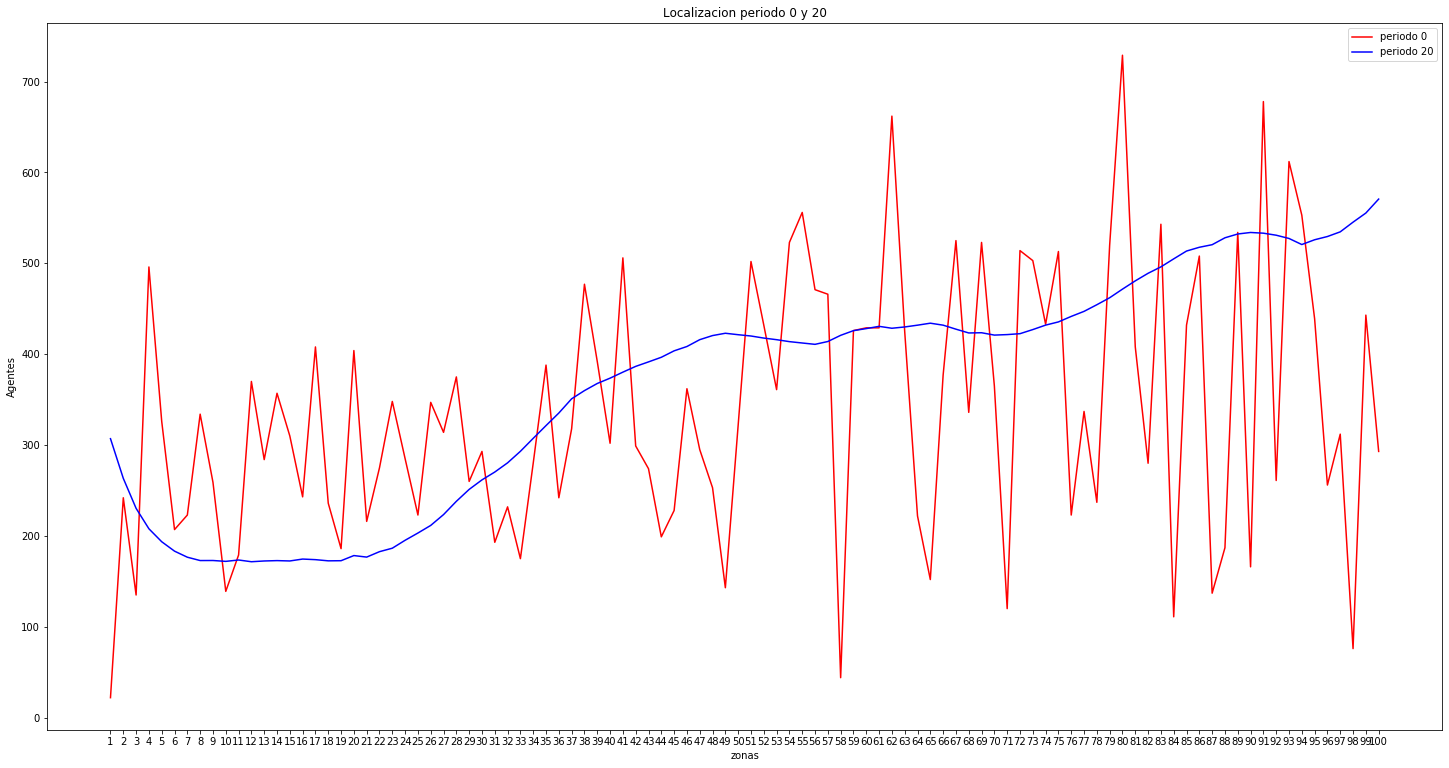

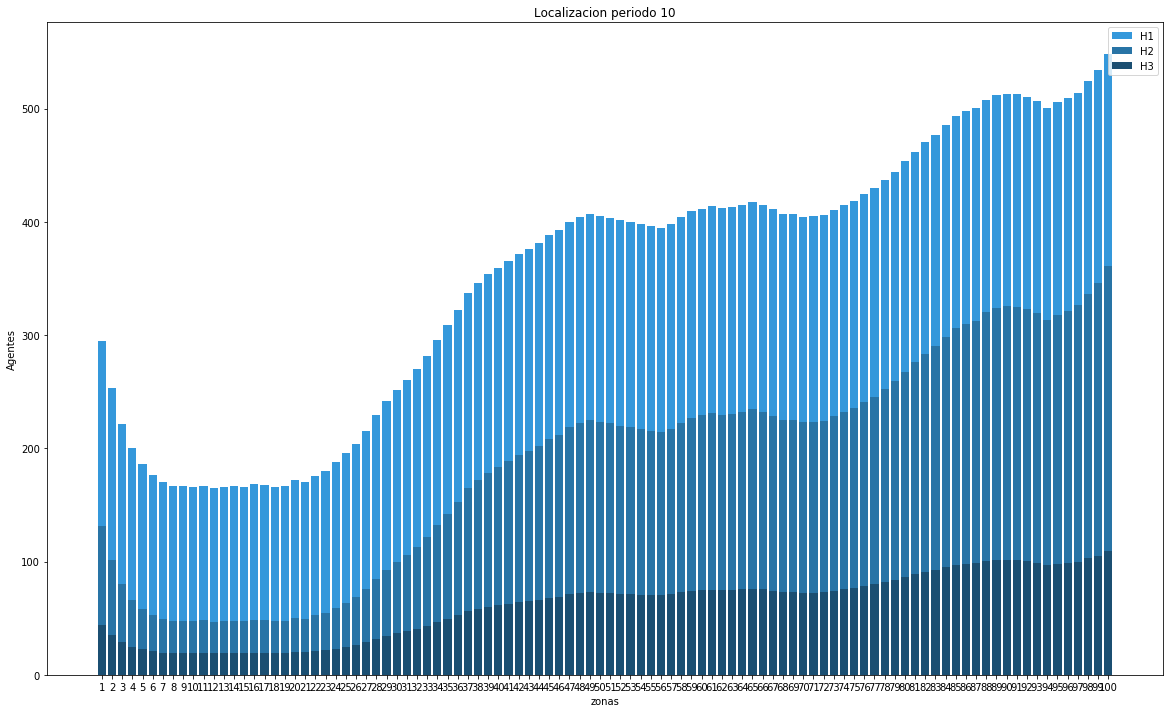

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from plot_eq import plot_lineas, plot_comparar

#Para comparar dos periodos distintos
plot_comparar(zona,zonas,0,20)

#Para plotear un periodo especifico y mostrar cada agente
plot_lineas(zona,zonas,10)